##Unsupervised Learning Part 2

The purpose of this section is to increase the number of US CBSAs that can be clustered by imputing the cluster labels (using knn) for CBSAs with some missing data in the 6 key pollutants. Then, we wanted to see if the clusters made in the US data could be used to classify the French data. 

In [242]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
from time import time
import operator 

####Import US data

In [159]:
clusters = pd.read_csv('dfClusters_kMeans.csv')
us_year = pd.read_csv('YearDat.csv')

####Import French data

In [410]:
france = pd.read_csv('FranceYearDat.csv')

###Impute cluster label of US cities with missing data in the 6 pollutants

In the previous cluster creation, only 80 of the 533 US CBSAs were able to be used because of missing data in the 6 key pollutants. So, to increase our sample size, we will use knn to impute the cluster assignment in the CBSAs with only one or two missing values (i.e., with data for 4 or 5 pollutants).

####What CBSAs have only one or two missing values in the key pollutants?

In [166]:
pollutants = ['CO', 'NO2', 'OZONE', 'PM10', 'PM25_FRMFEM', 'SO2']

#us_year_p is the dataframe with only the 6 pollutants, with CBSA name as the index. 
us_year_p = us_year.loc[:, ['CBSA Name', 'CO', 'NO2', 'OZONE', 'PM10', 'PM25_FRMFEM', 'SO2']]

In [172]:
#generate lists of CBSAs with data from 4 or 5 pollutants
us_p4 = []
us_p5 = []
for i, row in us_year_p.iterrows(): 
    count = []
    for item in row.index[1:]:
        if np.isnan(row[item]):
            count.append(1)
    if sum(count) == 1:
        us_p5.append(row['CBSA Name'])
    if sum(count) == 2:
        us_p4.append(row['CBSA Name'])

In [173]:
#how many CBSAs do we have with 4 or 5 pollutants?
print '%d CBSAs with non-missing data from 4 pollutants' %len(us_p4)
print '%d CBSAs with non-missing data from 5 pollutants' %len(us_p5)

64 CBSAs with non-missing data from 4 pollutants
42 CBSAs with non-missing data from 5 pollutants


There are 106 additional CBSAs that we can potentially add to our clustering. 

####Use knn to impute the cluster label

Adapted from: http://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [375]:
#full dataframe with 4 or 5 pollutants
us_year_pi = us_year_p.set_index('CBSA Name')
us_year_p4 = us_year_pi.loc[us_p4, :]
us_year_p5 = us_year_pi.loc[us_p5, :]

Write a function to find similarity between these CBSAs and the no missing data CBSAs. I used euclidean distance to calculate similarity.

In [376]:
def euclidean(miss_city, nonmiss_city, pollutant):
    distance = 0
    for pol in pollutant:
        distance += pow((miss_city[pol] - nonmiss_city[pol]), 2)
    return np.sqrt(distance)

I need to write a function that gives the right inputs to the euclidean function and iterates through all the cities.

In [377]:
def neighbors(clusteredcities, miss_city, k):
    distances = []
    #since the missing pollutant was different for each city, the "cols" list contains the pollutants with data.
    cols = []
    for x in range(len(miss_city)):
        if np.isnan(miss_city[x])==False:
            cols.append(miss_city.index[x])
    for x in range(len(clusteredcities)):
        dist = euclidean(miss_city, clusteredcities.iloc[x], cols)
        distances.append((clusteredcities.iloc[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

This 'neighbors' function gets the k nearest cities to a given city with missing values. The next function looks at the clusters in the neighboring cities and 'votes' for the most represented cluster.

In [378]:
def response(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x]['Cluster']
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

Finally, we put the functions together and get imputed clusters for each of our 106 cities with some missing data.

In [379]:
#for 4 pollutants
us_year_p4['Cluster'] = 0
for x in range(len(us_year_p4)):
    knn_clust = response(neighbors(clusters, us_year_p4.iloc[x,:], k=5))
    us_year_p4['Cluster'][x] = knn_clust

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [380]:
#same for 5 pollutants
us_year_p5['Cluster'] = 0
for x in range(len(us_year_p5)):
    knn_clust = response(neighbors(clusters, us_year_p5.iloc[x,:], k=5))
    us_year_p5['Cluster'][x] = knn_clust

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Output a .csv of all the clustered CBSAs so far.

In [381]:
us_year_p5['CBSA'] = us_year_p5.index
us_year_p4['CBSA'] = us_year_p4.index
allclusters = pd.concat([clusters, us_year_p4, us_year_p5])

In [382]:
allclusters = allclusters.reset_index(drop = True)

In [384]:
allclusters.to_csv("clusters_knn.csv",index=False,na_rep='NA')

###Visualize the clusters with the added CBSAs. How do they compare to the non-imputed clusters?

Note: reuse of code from Unsupervised Learning part 1

In [401]:
d=[]
for i in range(4):
    mean_PM25_FRMFEM = []
    mean_PM10 = []
    mean_CO=[]
    mean_NO2=[]
    mean_SO2=[]
    mean_OZONE=[]
    
    for x in range(len(allclusters)):
        if x == i:
            mean_PM25_FRMFEM.append(allclusters['PM25_FRMFEM'][x])
            mean_PM10.append(allclusters['PM10'][x])
            mean_CO.append(allclusters['CO'][x])
            mean_NO2.append(allclusters['NO2'][x])
            mean_SO2.append(allclusters['SO2'][x])
            mean_OZONE.append(allclusters['OZONE'][x])
    #create row for data frame to hold the means
    d.append({'Cluster':i,'Mean_PM25_FRMFEM':np.mean(mean_PM25_FRMFEM),'Mean_PM10':np.mean(mean_PM10),
              'Mean_CO':np.mean(mean_CO),'Mean_NO2':np.mean(mean_NO2),'Mean_SO2':np.mean(mean_SO2),
              'Mean_OZONE':np.mean(mean_OZONE)})
    
means = pd.DataFrame(d)
print means

   Cluster   Mean_CO   Mean_NO2  Mean_OZONE  Mean_PM10  Mean_PM25_FRMFEM  \
0        0  0.247224   7.093001    0.026165  27.801724         10.523564   
1        1  0.465238  18.273966    0.028158  23.560028         12.822971   
2        2  0.222915   8.467157    0.028324  32.308116         12.234181   
3        3  0.434787  22.318625    0.034657  26.029324          7.398333   

   Mean_SO2  
0  3.173781  
1  2.252641  
2  0.518919  
3  1.335092  


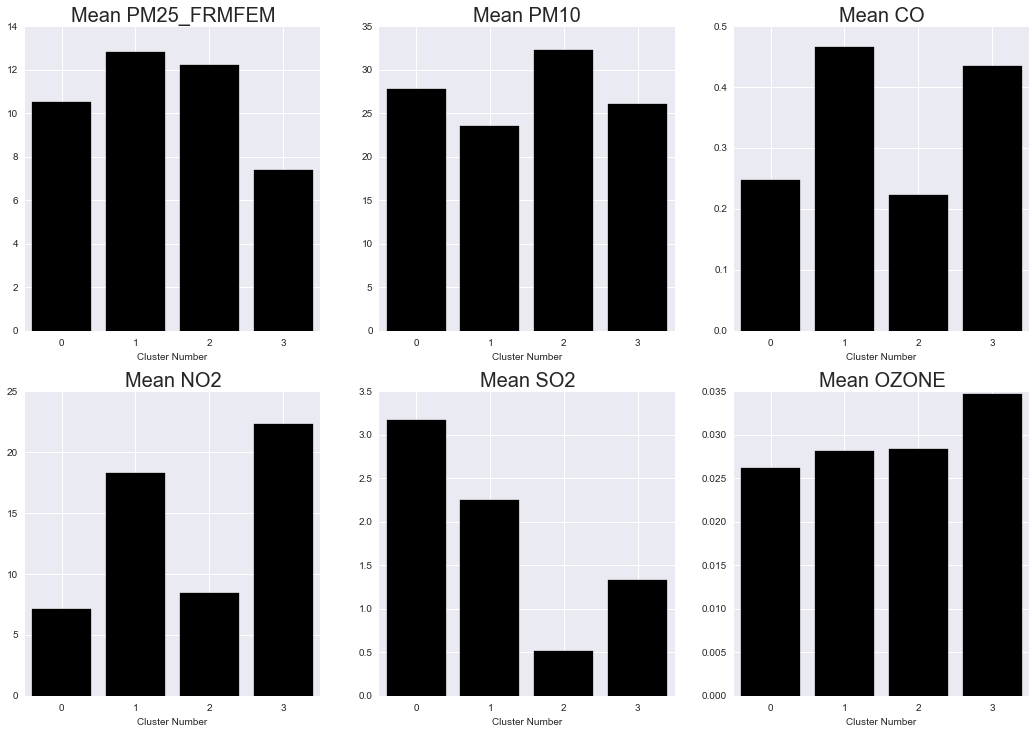

In [409]:
fig = plt.figure(figsize=(18,12))
names=['0','1','2','3']
plt.subplot(2, 3, 1)
plt.bar(means['Cluster'],means['Mean_PM25_FRMFEM'],color='black',align='center')
plt.title('Mean PM25_FRMFEM',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 2)
plt.bar(means['Cluster'],means['Mean_PM10'],color='black',align='center')
plt.title('Mean PM10',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 3)
plt.bar(means['Cluster'],means['Mean_CO'],color='black',align='center')
plt.title('Mean CO',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)
  
plt.subplot(2, 3, 4)
plt.bar(means['Cluster'],means['Mean_NO2'],color='black',align='center')
plt.title('Mean NO2',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 5)
plt.bar(means['Cluster'],means['Mean_SO2'],color='black',align='center')
plt.title('Mean SO2',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)

plt.subplot(2, 3, 6)
plt.bar(means['Cluster'],means['Mean_OZONE'],color='black',align='center')
plt.title('Mean OZONE',fontsize=20)
plt.xticks(means['Cluster'], names,horizontalalignment='center')
plt.xlabel('Cluster Number',horizontalalignment='center',fontsize=10)


###Clustering French data

First, I cut down the size of the french dataset to hold only the 6 key pollutants, and the cities that that have two or fewer missing values. 

In [411]:
france.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,id,population,popdense,...,PT,Other,latitude,longitude,Precip,Pressure,RH,Site,Temp,Wind
0,0.264047,13.533663,0.022437,24.659250,17.603,0.627990,Nancy,FR30036,434479,613.363951,...,52137.48,160757.23,48.649243,6.183765,734.1,1014.182698,NaN,071800-99999-2010,49.645806,5.602288
1,0.291703,13.180851,0.025806,22.641333,16.303,0.374618,Caen,FR21001,403633,667.231583,...,NaN,NaN,49.198722,-0.342557,709.9,1014.605930,NaN,070270-99999-2010,49.413654,7.613426
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051,106835,334.305710,...,NaN,NaN,49.745278,4.719167,796.0,1014.537853,NaN,070750-99999-2010,48.359738,4.522086
3,NaN,13.289894,0.025374,NaN,19.359,1.301908,Valence,FR36002,175636,657.229970,...,NaN,NaN,44.933514,4.893481,899.9,1013.618678,NaN,075770-99999-2010,55.345660,6.962982
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078,104917,483.925584,...,NaN,NaN,47.054444,-0.886111,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
france

,CO,NO2,OZONE,PM10,PM25,SO2,city,id,population,popdense,...,PT,Other,latitude,longitude,Precip,Pressure,RH,Site,Temp,Wind
0,0.264047,13.533663,0.022437,24.659250,17.6030,0.627990,Nancy,FR30036,434479,613.363951,...,52137.48,160757.23,48.649243,6.183765,734.1,1014.182698,NaN,071800-99999-2010,49.645806,5.602288
1,0.291703,13.180851,0.025806,22.641333,16.3030,0.374618,Caen,FR21001,403633,667.231583,...,NaN,NaN,49.198722,-0.342557,709.9,1014.605930,NaN,070270-99999-2010,49.413654,7.613426
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051,106835,334.305710,...,NaN,NaN,49.745278,4.719167,796.0,1014.537853,NaN,070750-99999-2010,48.359738,4.522086
3,NaN,13.289894,0.025374,NaN,19.3590,1.301908,Valence,FR36002,175636,657.229970,...,NaN,NaN,44.933514,4.893481,899.9,1013.618678,NaN,075770-99999-2010,55.345660,6.962982
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078,104917,483.925584,...,NaN,NaN,47.054444,-0.886111,NaN,NaN,NaN,NaN,NaN,NaN
5,0.346725,22.888431,0.020856,27.790000,18.7380,1.676240,Strasbourg,FR0286A,768868,1529.943989,...,92264.16,315235.88,48.609791,7.760652,820.6,1014.683378,NaN,071900-99999-2010,50.067383,5.394125
6,0.107424,11.407181,0.027324,26.141000,NaN,0.902290,Boulogne-sur-Mer,FR10031,133062,929.044722,...,NaN,NaN,50.703182,1.592245,NaN,NaN,NaN,NaN,NaN,NaN
7,0.237555,12.012766,0.021839,26.602000,NaN,0.557634,Arras,FR28022,128784,500.388799,...,NaN,NaN,50.308864,2.807369,NaN,NaN,NaN,073175-99999-2010,48.904664,8.481293
8,NaN,9.489362,0.031661,20.804000,15.0650,0.169847,Nimes,FR08614,259348,866.072503,...,NaN,NaN,43.834403,4.374219,701.8,1013.289360,NaN,076450-99999-2010,57.274885,6.342730
9,NaN,10.278191,0.020714,26.630000,NaN,0.767939,Bethune,FR28020,368633,2104.283433,...,14745.32,84785.59,50.490216,2.764275,NaN,NaN,NaN,NaN,NaN,NaN
